Tutorial 1: Non-linear Search
=============================

In this example, we're going to find a lens model that provides a good fit to an image, without assuming any knowledge
of what the `correct` lens model is.

So, whats a `lens model`? It is the combination of `LightProfile`'s and `MassProfile`'s we use to represent a lens galaxy,
source galaxy and therefore the strong lens ray-tracing configuration (i.e. the `Tracer`..

To begin, we have to choose the parametrization of our lens model. We don't need to specify the values of its light
and mass profiles (e.g. the centre, einstein_radius, etc.) - only the profiles themselves. In this example,
we'll use the following lens model:

 1) A `SphericalIsothermal` Sphere (SIS) for the lens galaxy's mass.
 2) A `SphericalExponential` `LightProfile` for the source-`Galaxy`'s light.

I'll let you into a secret - this is the same lens model used to simulate the `Imaging` data we're going to fit and
we're going to infer the actual parameters I used!

So, how do we infer the light and `MassProfile` parameters that give a good fit to our data?

Well, we could randomly guess a lens model, corresponding to some random set of parameters. We could use this
lens model to create a `Tracer` and fit the `Imaging` with it, via a `FitImaging` object. We can quantify how good the
fit is using its log likelihood (recall chapter_1/tutorial_8). If we kept guessing lens models, eventually we`d find
one that provides a good fit (i.e. high log_likelihood) to the data!

It may sound surprising, but this is actually the basis of how lens modeling works. However, we can do a lot better
than random guessing. Instead, we track the log likelihood of our previous guesses and guess more models using
combinations of parameters that gave higher log_likelihood solutions previously. The idea is that if a set of parameters
provided a good fit to the data, another set with similar values probably will too.

This is called a `non-linear search` and its a fairly common problem faced by scientists. Over the next few tutorials,
we're going to really get our heads around the concept of a `NonLinearSearch` - intuition which will prove crucial to
being a successful lens modeler.

An animation of a `NonLinearSearch` fitting a lens model can be found on the following page on our readthedocs. Note
how the initial models that it fits give a poor fit to the data, but gradually improve as more iterations are performed.

 `https://pyautolens.readthedocs.io/en/latest/overview/modeling.html`

we're going to use a `NonLinearSearch` called `Dynesty`. I highly recommend it, and find its great for
lens modeling. However, for now, lets not worry about the details of how Dynesty actually works. Instead, just
picture that a `NonLinearSearch` in **PyAutoLens** operates as follows:

 1) Randomly guess a lens model and use its `LightProfile`'s and `MassProfile`'s to set up a lens galaxy, source galaxy
 and a `Tracer`.

 2) Use this `Tracer` and a `MaskedImaging` to generate a model image and compare this model image to the
 observed strong lens `Imaging` data using a `FitImaging` object, providing the log likelihood.

 3) Repeat this many times, using the likelihoods of previous fits (typically those with a high log_likelihood) to
 guide us to the lens models with the highest log likelihood.

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af  # <- This library is used for non-linear fitting.
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


You`re going to see a line like the one below (with `conf.instance =`) in every tutorial this chapter. This sets the
following two properties:

 - The path to the configuration files used by **PyAutoLens**, some of which configure the non-linear search. You need 
   to give the path to your autolens_workspace, so the configuration files in the workspace are used (e.g. 
   `autolens_workspace/config`). 

 - The path to the **PyAutoLens** output folder, which is where the results of the `NonLinearSearch` are written to 
   on your hard-disk, alongside visualization and other properties of the fit 
   (e.g. `autolens_workspace/output/howtolens`)

(These will work autommatically if the WORKSPACE environment variable was set up correctly during installation. 
Nevertheless, setting the paths explicitly within the code is good practise.

Lets loads the `Imaging` dataset we'll fit a lens model with using a non-linear search. If you are interested in how
we simulate strong lens data, checkout the scripts in the folder `autolens_workspace/howtolens/simulators`.

The strong lens in this image was generated using:

 - The lens galaxy's total mass distribution is a *SphericalIsothermal*.
 - The source galaxy's `LightProfile` is a *SphericalExponential*.

This dataset (and all datasets used in tutorials from here are on) are stored and loaded from the 
`autolens_workspace/dataset/imaging` folder.

In [2]:
dataset_name = "mass_sis__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

The non-linear fit also needs a `Mask2D`, lets use a 3.0" circle.

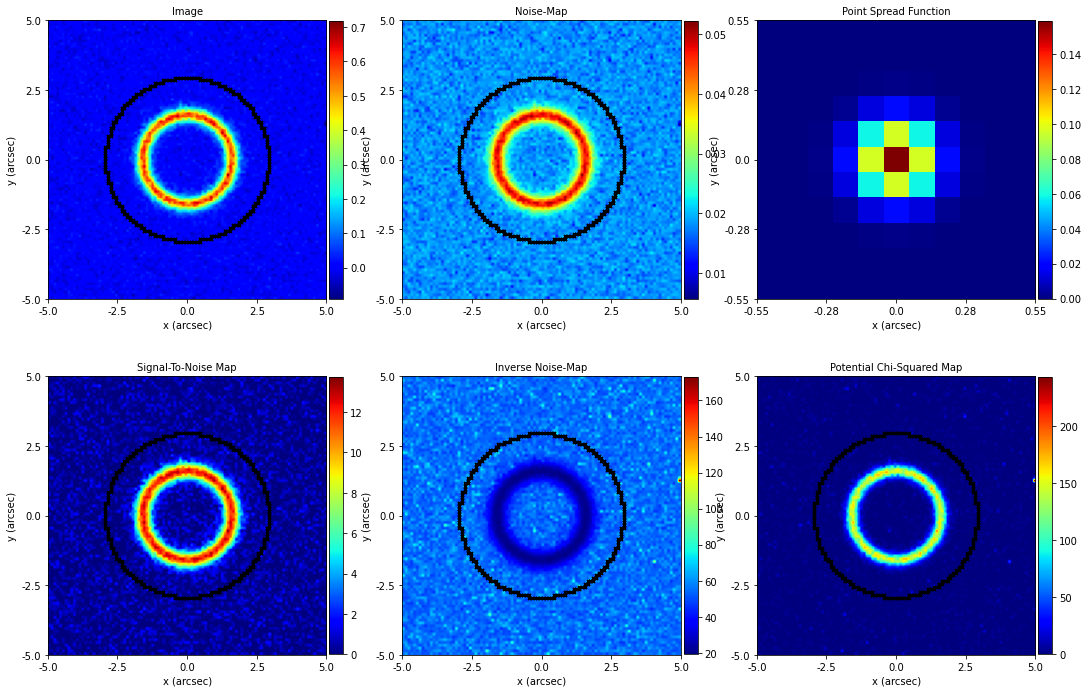

In [3]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

To compute a lens model, we use a `GalaxyModel`, which behaves analogously to the `Galaxy` objects we're now used to. 
However, whereas for a `Galaxy` we manually specified the value of every parameter of its `LightProfile`'s and 
`MassProfile`'s, for a `GalaxyModel` these are fitted for and inferred by the non-linear search.

Lets model the lens galaxy with an `SphericalIsothermal` `MassProfile`.(which is what it was simulated with).

In [4]:
lens_galaxy_model = al.GalaxyModel(redshift=0.5, mass=al.mp.SphericalIsothermal)

Lets model the source galaxy with a spherical exponential `LightProfile` (again, what it was simulated with).

In [5]:
source_galaxy_model = al.GalaxyModel(redshift=1.0, bulge=al.lp.SphericalExponential)

We can use a `SettingsPhaseImaging` object to customize how a `Tracer` and `FitImaging` are used to fit the `Imaging` 
dataset. Below, we specify:

 - That a regular `Grid2D` is used to fit create the model-image when fitting the data 
 (see `autolens_workspace/examples/grids.py` for a description of grids).
 - The sub-grid size of this grid.

These settings are passed to `SettingsPhaseImaging` via a `SettingsMaskedImaging` object, which in the previous chapter
we saw could be used to customize how the `MaskedImaging` was setup. All settings passed to a `SettingsPhaseImaging`
object are passed in this way, thus the settings we input into a phase are categorized based on what they change.

You'll note that the output folder of non-linear seach results has been `tagged` with these phase settings. we'll 
discuss this and phase settings in more detail in a later tutorial.

In [6]:
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D, sub_size=2)

settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

To fit the galaxy models above via a `NonLinearSearch` (in this case, Dynesty) we use a `PhaseImaging` object. searches
bring together the model, `NonLinearSearch` and data, in order to perform a model-fit and thus infer a lens model.

(Just like we could give profiles descriptive names, like `light`, `bulge` and `disk`, we can do the exact same 
thing with the phase`s galaxies. This is good practise - as once we start using complex lens models, you could 
potentially have a lot of galaxies - and this is the best way to keep track of them!).

You'll note that we also pass the `NonLinearSearch` the following:
 
 - Input parameters like `n_live_points` and `walks` controlling how it samples parameter space. we'll cover what 
   these do in a later tutorial.  The results full output path are `tagged` depending on these settings.
 - A `path_prefix` which tells the search to output its results in the folder `autolens_workspace/output/howtolens/`. 
 - A `name`, which gives the search a name and means the full output path is 
   `autolens_workspace/output/howtolens/phase_t1_non_linear_search`. 

In [7]:
phase = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="howtolens", name="phase_t1_non_linear_search", n_live_points=40
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(
        lens_galaxy=lens_galaxy_model, source_galaxy=source_galaxy_model
    ),
)

To run the phase, we pass it the data we're going to fit a lens model to and the `NonLinearSearch` begins!

Model fits using a `NonLinearSearch` can take a long time to run. Whilst the fit in this tutorial should take of order 
~10 minutes, later tutorials will take upwards of hours! This is fine, afterall lens modeling is an inherently 
computationally expensive exercise, but does make going through these tutorials problematic.

Furthermore, in a Jupyter notebook, if you run the `NonLinearSearch` (using the phase.run command below) you won't 
be able to continue the notebook until it has finished. For this reason, we recommend that you run the non-linear
search in these tutorials not via your Jupyter notebook, but instead by running the tutorial script found in the
`chapter_2_lens_modeling/scripts` folder. This can be run either using the `python3 tutoial_1_non_linear_search.py` 
command on your command line or via your IDE (if you are using one).

The `NonLinearSearch` outputs all results to your hard-disk, thus if it runs and finishes in the script, you can then
run the Jupyter notebook cell and immediately load the result. This is how we recommend all non-linear searches are 
performed in **PyAutoLens** and is therefore a good habit to get into. In these tutorials, we have commented the 
`phase.run` command below in every cell to remind you that you should go to the tutorial script in the 
`chapter_2_lens_modeling/scripts` folder, uncomment the line and run the entire script!

In [8]:
print(
    "Dynesty has begun running - checkout the autolens_workspace/output/"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

result = phase.run(dataset=imaging, mask=mask)

print("Dynesty has finished run - you may now continue the notebook.")

Dynesty has begun running - checkout the autolens_workspace/output/ folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!


INFO:root:phase_t1_non_linear_search already completed, skipping non-linear search.


Dynesty has finished run - you may now continue the notebook.


Now this is running you should checkout the `autolens_workspace/output` folder.

This is where the results of the phase are written to your hard-disk (in the `1_non_linear_search` folder). When its 
completed, images and output will also appear in this folder, meaning that you don't need to keep running Python 
code to see the result.

In fact, even when a phase is running, it outputs the the current maximum log likelihood results of the lens model 
to your hard-disk, on-the-fly. If you navigate to the output/howtolens folder, even before the phase has finished, 
you'll see:

 1) The `image` folder, where the current maximum log likelihood lens model `Tracer` and `FitImaging` are visualized 
 (again, this outputs on-the-fly).
 
 2) The file `samples/samples.csv`, which contains a table-format list of every sample of the non-linear search
 complete with log likelihood values.
 
 3) The `model.info` file, which lists all parameters of the lens model and their priors.
 
 4) The `model.results` file, which lists the current best-fit lens model (this outputs on-the-fly).
 
 5) The `output.log` file, where all Python interpreter output is directed.

The best-fit solution (i.e. the maximum log likelihood) is stored in the `results`, which we can plot as per usual 
(you must wait for the `NonLinearSearch` to finish before you can get the `results` variable). we'll discuss the 
`results` returned by a phase in detail at the end of the chapter.

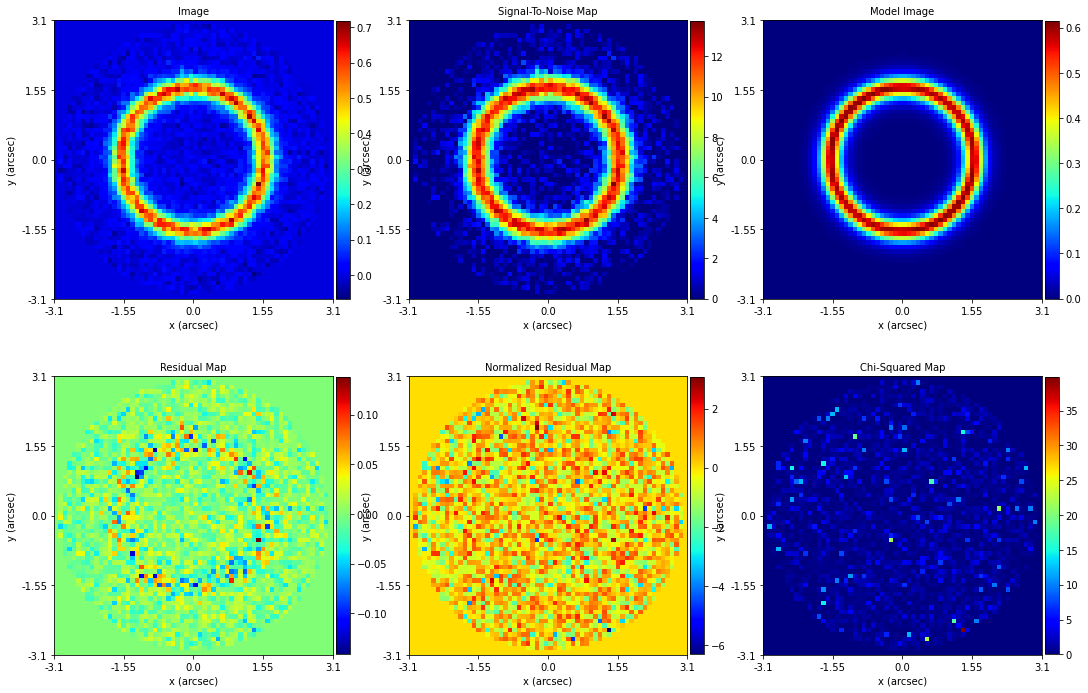

In [9]:
fit_imaging_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

The fit looks good and we've therefore found a model close to the one I used to simulate the image with (you can 
confirm this yourself if you want, by comparing the inferred parameters to those found in the script
`autolens_workspace/notebooks/imaging/simulators/no_lens_light/mass_sis__source_sersic.py`).

And with that, we're done - you`ve successfully modeled your first strong lens with **PyAutoLens**! Before moving onto the 
next tutorial, I want you to think about the following:

 1) a `NonLinearSearch` is often said to search a `non-linear parameter-space` - why is the term parameter-space 
 used?

 2) Why is this parameter space 'non-linear'?

 3) Initially, the `NonLinearSearch` randomly guesses the values of the parameters. However, it shouldn`t `know` 
 what reasonable values for a parameter are. For example, it doesn`t know that a reasonable Einstein radius is 
 between 0.0" and 4.0"). How does it know what are reasonable values of parameters to guess?